# Exploring a Direct-Marketing Data Set - Preliminary Analysis
### (Uses code snippets and ideas from Kevin L. Davenport and Sebastian Raschka)

In [4]:
# Import packages
import time
import csv
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import wraps
from matplotlib.font_manager import FontProperties
from scipy import interp

/Users/jsubapple/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [5]:
# Import SciKit Learn packages
from sklearn import model_selection #where the cross_validation and learning_curve modules live
from sklearn import neighbors
from sklearn import preprocessing
from sklearn import tree
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

In [6]:
%matplotlib inline

In [7]:
%%html
<!-- make markdown table pretty -->
<style>table {float:left}</style>

## Get the Data

In [8]:
# Load the data
# This is the Bank Marketing data set at the UCI Machine Learning Repository
# archive.ics.uci.edu/ml/datasets/Bank+Marketing
import os
data = pd.read_csv(os.getcwd() + '/Data/bank-additional/bank-additional-full.csv', sep=';')

In [9]:
# data sanity check -- go ahead and scroll to the right to see the complete table.
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [10]:
data.shape

(41188, 21)

## What the Data Attributes Mean

**Bank Client Data**

* 1 - age (numeric)
* 2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
* 3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
* 4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
* 5 - default: has credit in default? (categorical: 'no','yes','unknown')
* 6 - housing: has housing loan? (categorical: 'no','yes','unknown')
* 7 - loan: has personal loan? (categorical: 'no','yes','unknown')
related with the last contact of the current campaign:
* 8 - contact: contact communication type (categorical: 'cellular','telephone') 
* 9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
* 10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
* 11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

** Other Attributes**

* 12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
* 13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
* 14 - previous: number of contacts performed before this campaign and for this client (numeric)
* 15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

**Social and Economic Context Attributes**

* 16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
* 17 - cons.price.idx: consumer price index - monthly indicator (numeric) 
* 18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric) 
* 19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
* 20 - nr.employed: number of employees - quarterly indicator (numeric)

**Output Variable (Desired Target)**

* 21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

## Rename Columns as Needed

In [11]:
# Rename the economic and social indicator columns -- they contain dots in their names and are a pain to work with
data = data.rename(columns={'emp.var.rate': 'emp_var_rate', 'cons.price.idx': 'cons_price_idx', 'cons.conf.idx': 'cons_conf_idx', 'nr.employed': 'nr_employed'})
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [12]:
# Here are all the column names in the dataset
list(data)

['age',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed',
 'y']

## Check for Missing Data and Handle as Needed

In [88]:
# First we'll see if there are missing values -- always a good thing to check.
data.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64

That's nice! There are no missing values. 
If we had missing data, there are a number of ways to handle that.

We know that there are no empty cells in the dataframe. However, note that some features have the value "unknown". Let's see how many of these we have. This should also give us good information about how the categorial attributes in our dataset are distributed.

In [16]:
# Attributes that are categorical
cat_col_names = ['job', 'marital', 'education', 'default', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']
[data[col_name].value_counts() for col_name in cat_col_names]

[admin.           10422
 blue-collar       9254
 technician        6743
 services          3969
 management        2924
 retired           1720
 entrepreneur      1456
 self-employed     1421
 housemaid         1060
 unemployed        1014
 student            875
 unknown            330
 Name: job, dtype: int64, married     24928
 single      11568
 divorced     4612
 unknown        80
 Name: marital, dtype: int64, university.degree      12168
 high.school             9515
 basic.9y                6045
 professional.course     5243
 basic.4y                4176
 basic.6y                2292
 unknown                 1731
 illiterate                18
 Name: education, dtype: int64, no         32588
 unknown     8597
 yes            3
 Name: default, dtype: int64, no         33950
 yes         6248
 unknown      990
 Name: loan, dtype: int64, cellular     26144
 telephone    15044
 Name: contact, dtype: int64, may    13769
 jul     7174
 aug     6178
 jun     5318
 nov     4101
 apr     

In [17]:
# The data set is imbalanced -- i.e., it's rare for people to to say yes -- only 1 of 9 people say yes. 
# Accuracy alone as a measure of performance won't cut it. Have to use precision and recall.
data['y'].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

In [18]:
# Previous defaults on a loan -- we don't have enough data for this to be a useful feature -- can you see why?
data['default'].value_counts()

no         32588
unknown     8597
yes            3
Name: default, dtype: int64

## Overall Statistics for the Continuous Attributes

In [14]:
# Pandas will automatically select just the continuous variables
data.describe()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


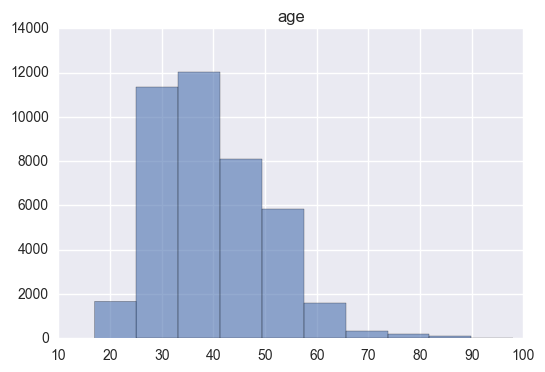

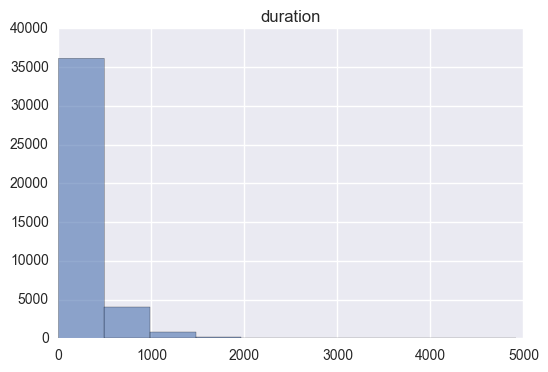

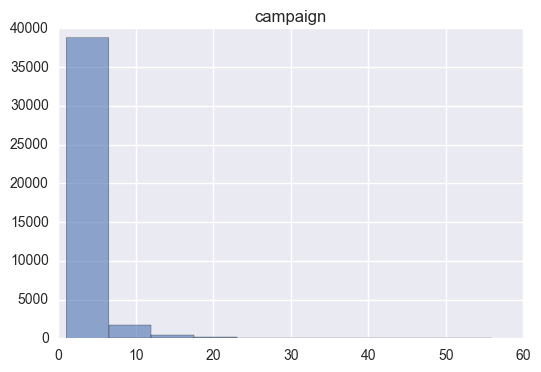

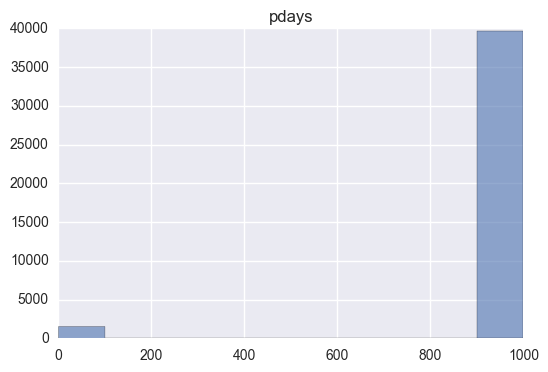

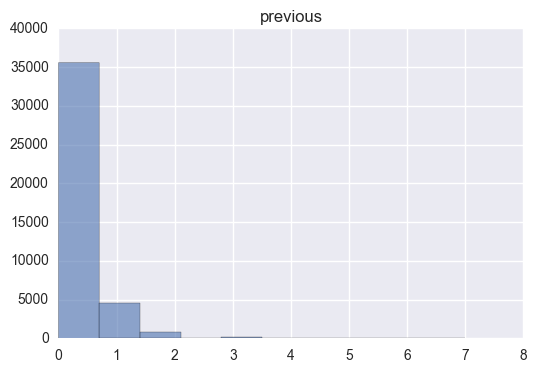

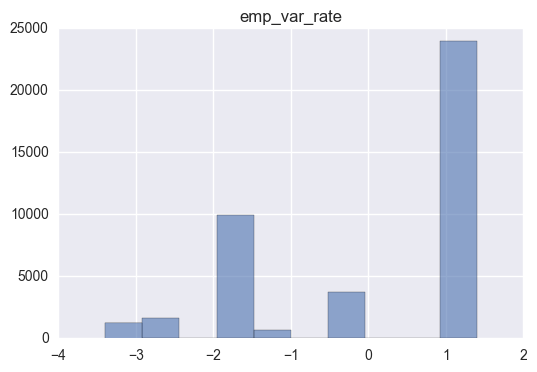

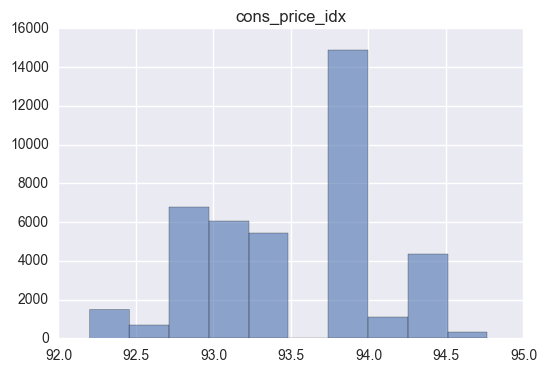

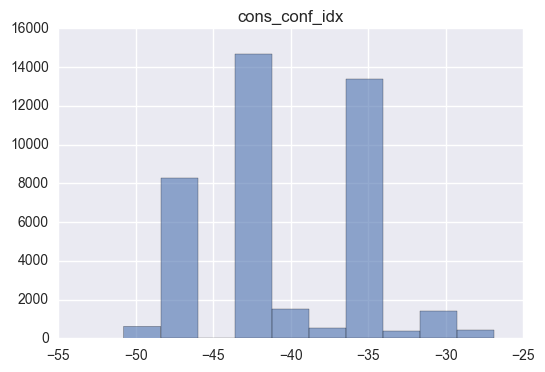

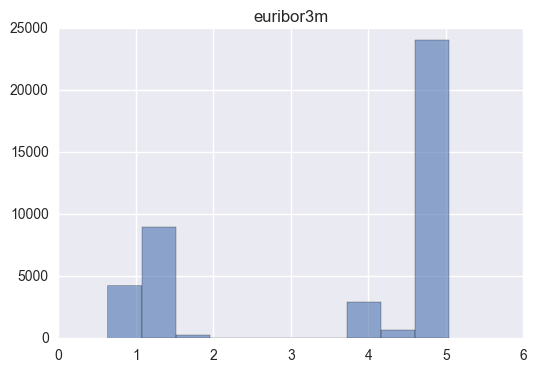

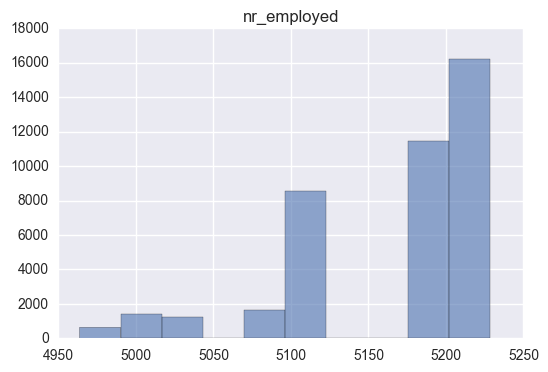

In [21]:
# Continuous attributes -- histograms to check their distribution
cont_cols = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate', 
             'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']
#fig, axs = plt.subplots(ncols=3)
#sns.regplot(x='value', y='wage', data=df_melt, ax=axs[0])
#sns.regplot(x='value', y='wage', data=df_melt, ax=axs[1])
#sns.boxplot(x='education',y='wage', data=df_melt, ax=axs[2])
for i in range(len(cont_cols)): 
    plt.figure(i)
    plt.title(cont_cols[i])
    data[cont_cols[i]].hist(alpha=0.6)
plt.show()

Clearly, a number of campaign-related features such as pdays are terribly imbalanced. We could just drop them right away 

## Pickle the Dataset for Use in Other Notebooks

In [13]:
# Pickle this dataframe for use in other notebooks
data.to_pickle(os.getcwd() + '/Data/bank-additional/bank-additional-full_pickled')

# Visualize Connections Between Attributes

In any data set like this one, there are many questions to ask. Does persistence on the part of the salesperson make a difference? When does persistence pay off and when does it backfire? Does the day of the week on which the final call is made make a difference to those who bought? And there are many many more.

Perhaps you can read off from the plots below, things like:
- If a person already has a loan, then persistence doesn't pay off (first row, second column)
- Most people who have a loan buy after at most 3 calls (row 2, column 2)
- If the prospect's loan status is not known, then don't all more than 5 times -- it's a waste. (row 2, column 3)
- In general, it's never a good idea to call more than 10 times. Stop and regroup. (All plots)

### Facet Plots

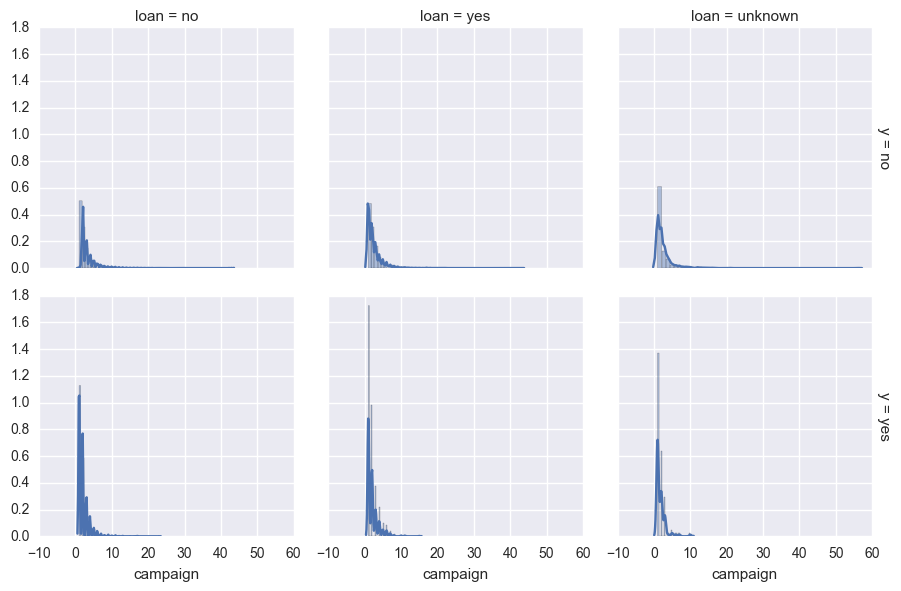

In [11]:
g = sns.FacetGrid(data, row='y', col='loan', margin_titles=True)
g.map(sns.distplot, 'campaign')

### Density Histograms

That's nice. And we can also look quickly to see whether a person buys or not depends on a characteristic they have. For example, in the plot below, we see if there's a difference in age between those who buy and those who don't.

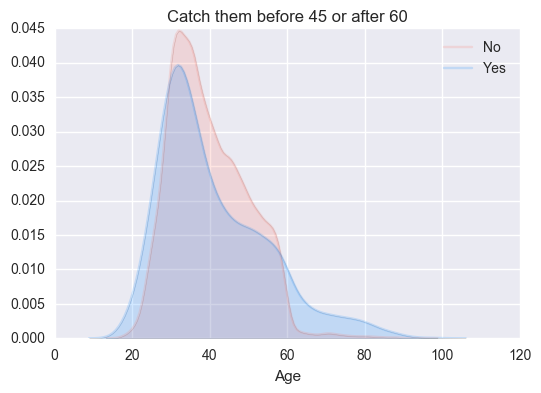

In [12]:
sns.kdeplot(data.query("y == 'no'").age, shade=True, alpha=0.2, label='No', color='salmon')
sns.kdeplot(data.query("y == 'yes'").age, shade=True, alpha=0.2, label='Yes', color='dodgerblue')
plt.title('Catch them before 45 or after 60')
plt.xlabel('Age')

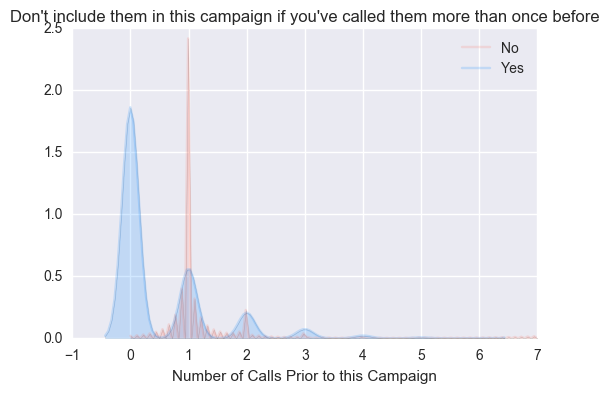

In [13]:
sns.kdeplot(data.query("y == 'no'").previous, shade=True, alpha=0.2, label='No', color='salmon')
sns.kdeplot(data.query("y == 'yes'").previous, shade=True, alpha=0.2, label='Yes', color='dodgerblue')
plt.title("Don't include them in this campaign if you've called them more than once before")
plt.xlabel('Number of Calls Prior to this Campaign')

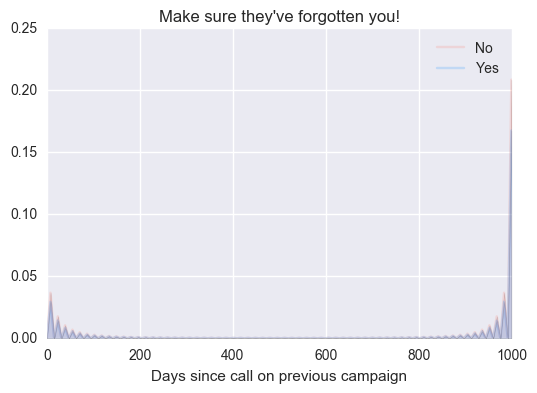

In [14]:
sns.kdeplot(data.query("y == 'no'").pdays, shade=True, alpha=0.2, label='No', color='salmon')
sns.kdeplot(data.query("y == 'yes'").pdays, shade=True, alpha=0.2, label='Yes', color='dodgerblue')
plt.title("Make sure they've forgotten you!")
plt.xlabel('Days since call on previous campaign')

How do economic variables affect buying behavior?

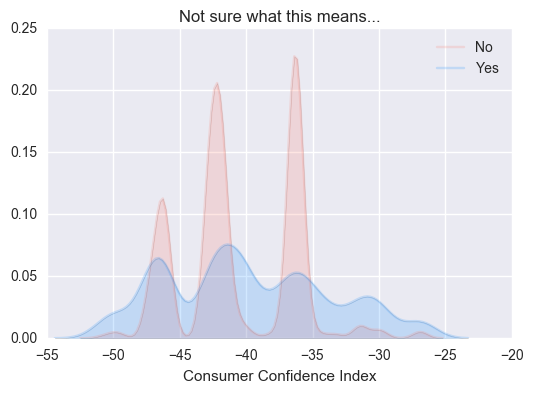

In [15]:
sns.kdeplot(data.query("y == 'no'").cons_conf_idx, shade=True, alpha=0.2, label='No', color='salmon')
sns.kdeplot(data.query("y == 'yes'").cons_conf_idx, shade=True, alpha=0.2, label='Yes', color='dodgerblue')
plt.title("Not sure what this means...")
plt.xlabel('Consumer Confidence Index')

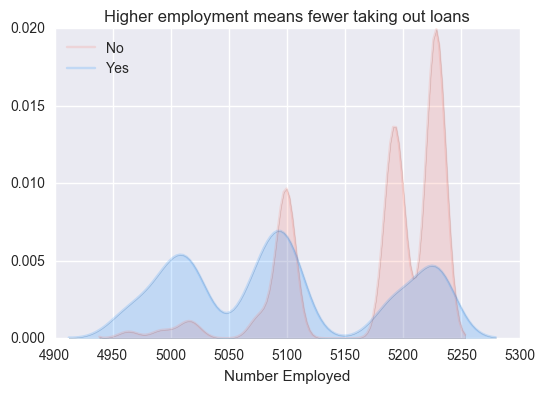

In [16]:
sns.kdeplot(data.query("y == 'no'").nr_employed, shade=True, alpha=0.2, label='No', color='salmon')
sns.kdeplot(data.query("y == 'yes'").nr_employed, shade=True, alpha=0.2, label='Yes', color='dodgerblue')
plt.title("Higher employment means fewer taking out loans")
plt.xlabel('Number Employed')

### Pivots

For attributes that are categorical we could see how buying behavior pans out.

In [17]:
# How poutcome -- whether the prospect has bought on the previous campaign -- influences buying behavior 
# in this campaign
gb_poutcome = data.groupby(by=['poutcome','y'])
gbs = gb_poutcome.size()
gbs

poutcome     y  
failure      no      3647
             yes      605
nonexistent  no     32422
             yes     3141
success      no       479
             yes      894
dtype: int64

Clearly, having bought before is a great indicator of whether a prospect will buy this time around.

In [18]:
# How day_of_week -- influences buying behavior 
gb_day = data.groupby(by=['day_of_week','y'])
gbs = gb_day.size()
gbs

day_of_week  y  
fri          no     6981
             yes     846
mon          no     7667
             yes     847
thu          no     7578
             yes    1045
tue          no     7137
             yes     953
wed          no     7185
             yes     949
dtype: int64

Call on Tuesdays, Wedenesdays, and Thursdays. Try having your best staff working on Mondays and Fridays and see if that makes any difference. 

In [19]:
# Does already having a loan influence buying behavior?
gb_loan = data.groupby(by=['loan','y'])
gbs = gb_loan.size()
gbs

loan     y  
no       no     30100
         yes     3850
unknown  no       883
         yes      107
yes      no      5565
         yes      683
dtype: int64

It's not clear just from the table above if already having a loan influences buying a new loan. How about if one has defaulted on a loan previously?

In [20]:
# Does defaulting on a loan influence buying behavior?
gb_default = data.groupby(by=['default','y'])
gbs = gb_default.size()
gbs

default  y  
no       no     28391
         yes     4197
unknown  no      8154
         yes      443
yes      no         3
dtype: int64

It's murky -- there doesn't seem to be enough data to tell one way or the other.

### Pairwise Scatter Plots

In [12]:
# Pairwise scatter plots of the campaign attributes (these features all have numeric values)
cols_campaign = ['age', 'duration', 'campaign', 'pdays', 'previous']

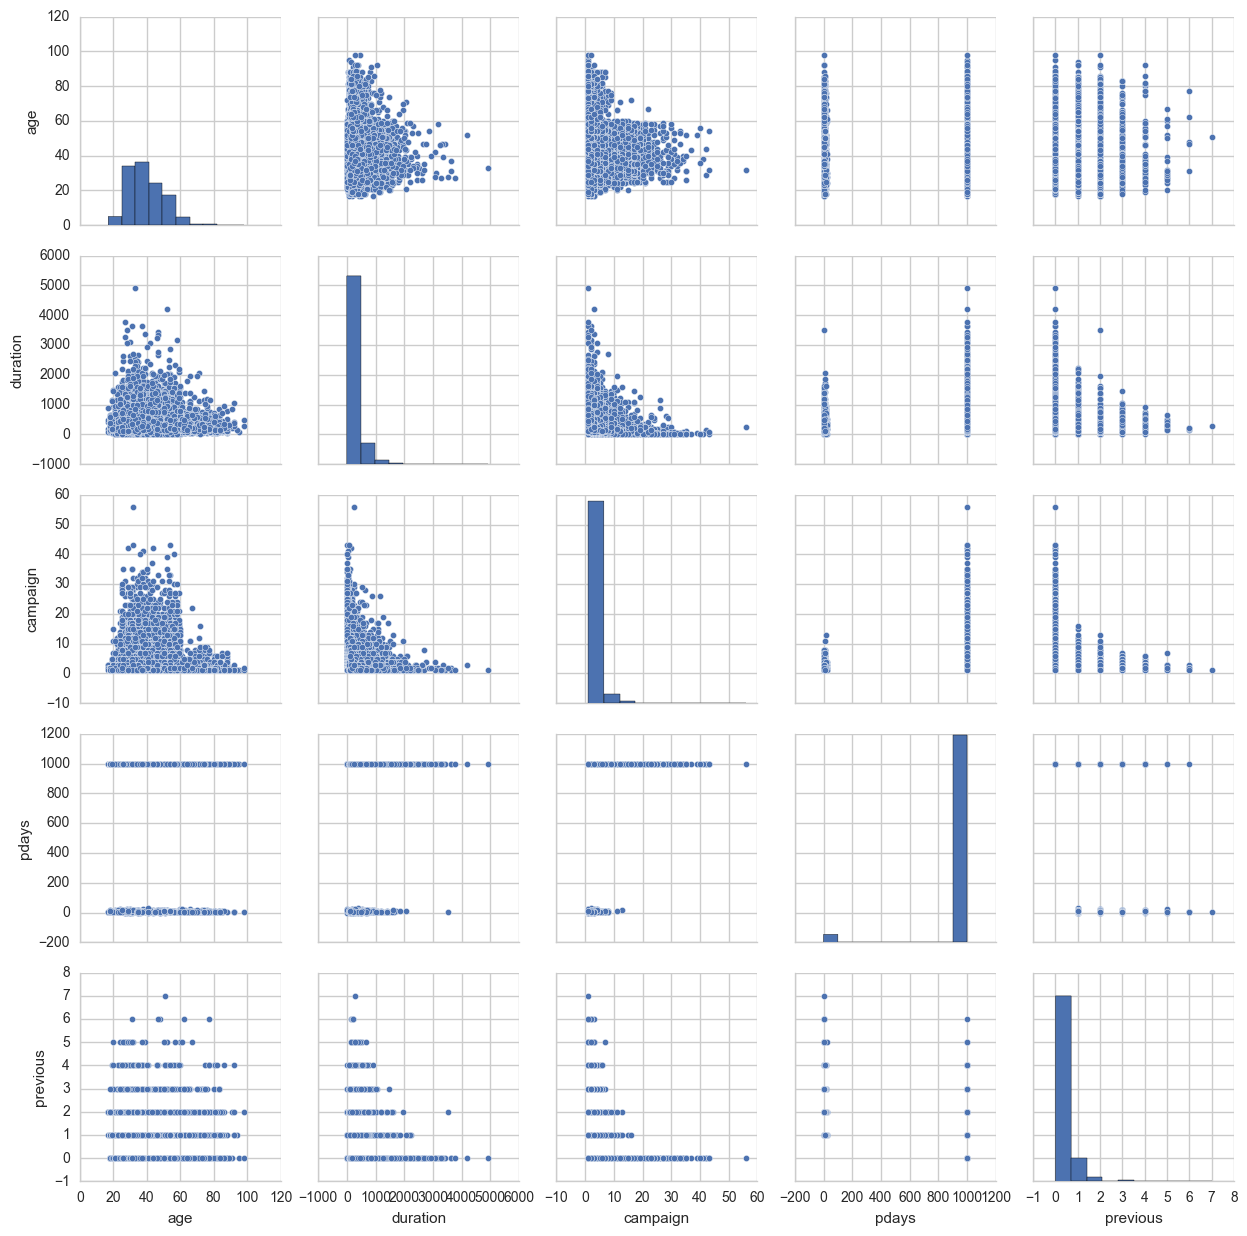

In [26]:
sns.set(style='whitegrid', context='notebook')
sns.pairplot(data[cols_campaign], size=2.5)

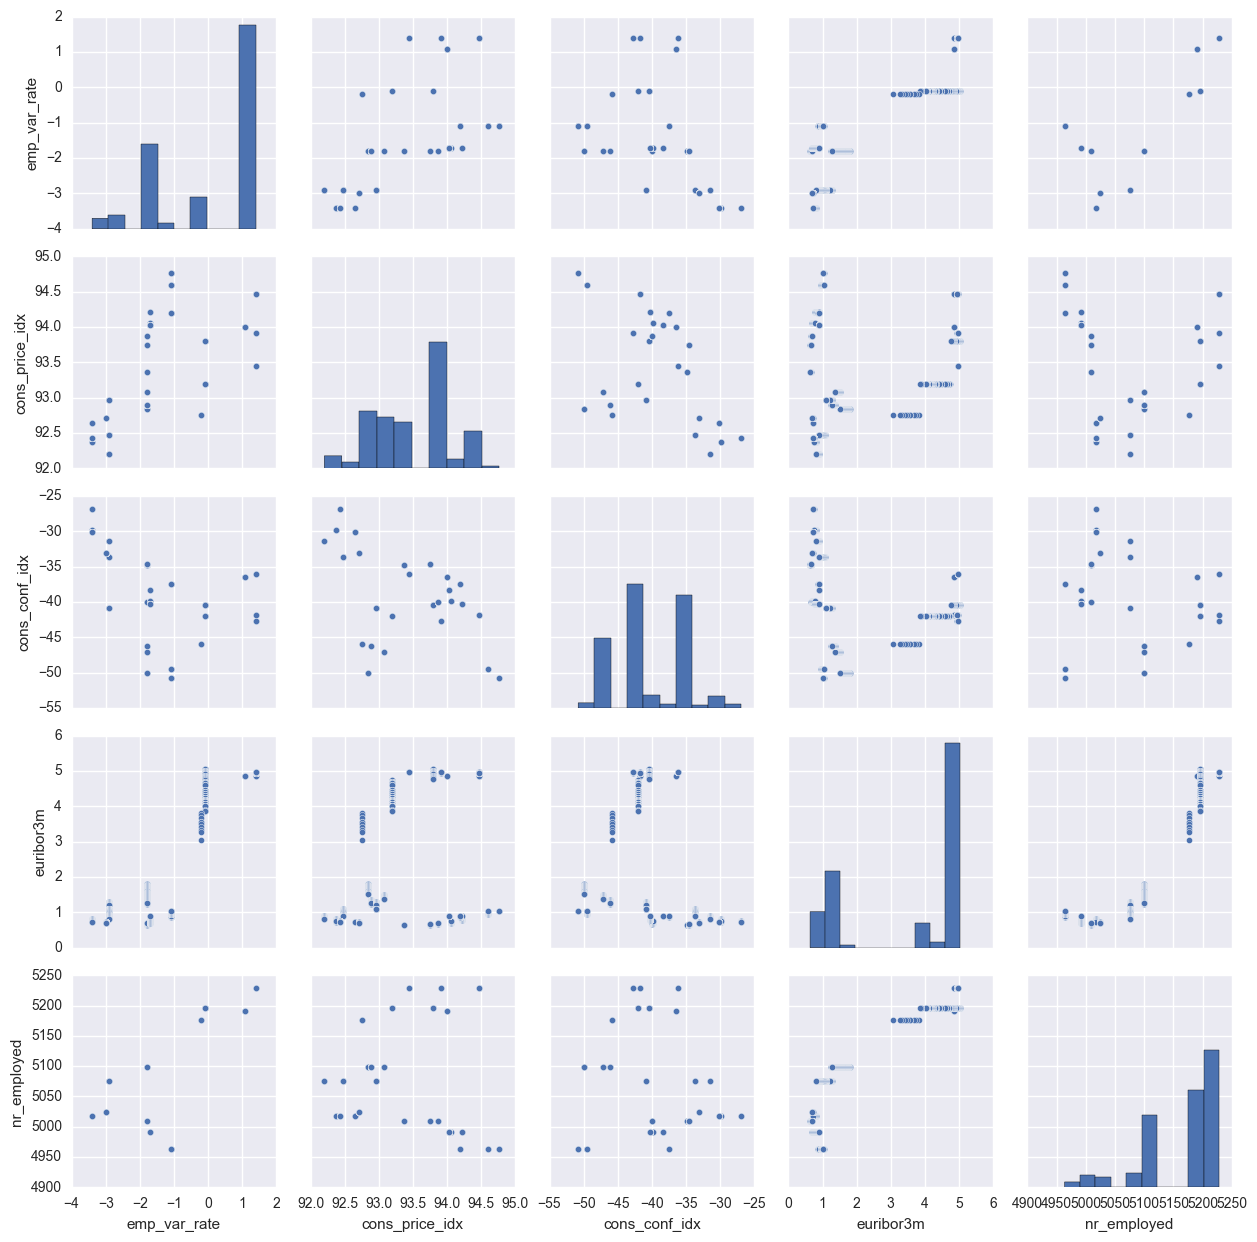

In [13]:
# Pairwise scatter plots of economic attributes (these features all have numeric values)
cols_econ = ['emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']
sns.pairplot(data[cols_econ], size=2.5)

### Correlation Tables

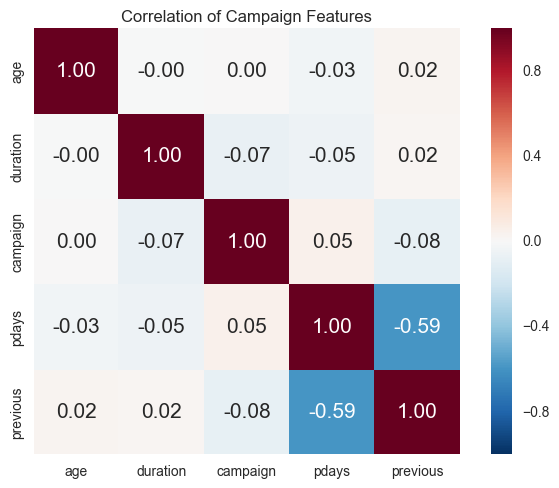

In [24]:
# Correlation table for campaign attributes
cm = np.corrcoef(data[cols_campaign].values.T)
sns.set(font_scale=1)
# NOTE: fmt directive controls number of decimal points displayed
hm = sns.heatmap(cm,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws={'size':15},
                yticklabels=cols_campaign,
                xticklabels=cols_campaign)
plt.title('Correlation of Campaign Features')

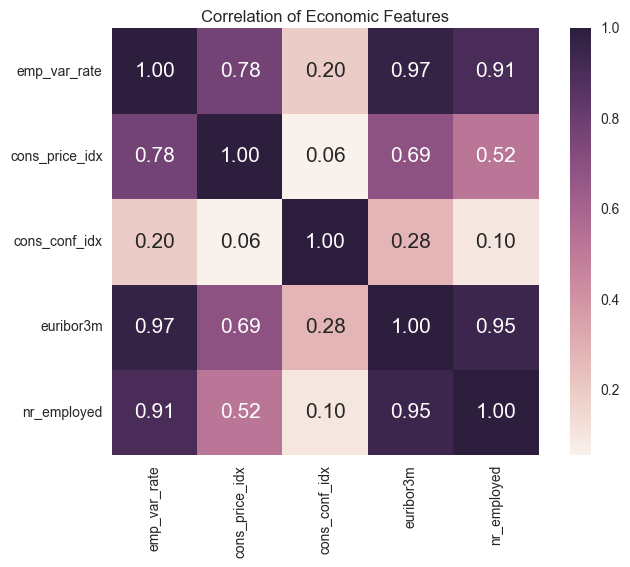

In [25]:
# Correlation table for economic attributes
cm = np.corrcoef(data[cols_econ].values.T)
sns.set(font_scale=1)
# NOTE: fmt directive controls number of decimal points displayed
hm = sns.heatmap(cm,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws={'size':15},
                yticklabels=cols_econ,
                xticklabels=cols_econ)
plt.title('Correlation of Economic Features')

And so it goes with just plain exploratory data analysis - sometimes things can jump out and surprise you. Other times not. It's an exploration after all. But there are some standard ways to visualize things -- let's recap.

1) Facet plots to see how outcome varies for continous-value features

2) Density histograms for how outcome varies for continuos-value features

3) Pivot tables to see how outcome varies for the discrete-value features

4) Scatter plots

5) Correlation matrices

The problem is none of these can give us anything definitive to say. They can give you directional guidance but can't really help if you're looking to make precise predictions. In the Feature-Selection notebook, we'll look at some ways to evaluate the features from the standpoint of the data set as a whole. 